In [11]:
# dependencies

import datetime
import pickle as pkl

import numpy as np
import pandas as pd
import pystan as stan
import matplotlib.pyplot as plt
import seaborn as sns

import xfx.unid_mult.gibbs
import xfx.misc.plot

In [12]:
# helper functions

def package_cgibbs_samples(samples, factor_names, response_names):

    rfx_samples, prec_samples = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3).T
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'cGibbs'), package_prec_samples(prec_samples, factor_names, 'cGibbs')

def package_nuts_samples(samples, data, factor_names, response_names):

    alp0_samples = samples['intercept'][:, 0, :-1]
    alp_samples = [[alp_[:, lo:(hi+1)].T for lo, hi in zip(data['lo'] - 1, data['hi'] - 1)] for alp_ in samples['coefs'][:, 0, :-1]]
    rfx_samples = [np.array(samples_) for samples_ in zip(*[[alp0_[np.newaxis]] + alp_ for alp0_, alp_ in zip(alp0_samples, alp_samples)])]
    prec_samples = np.array([[np.trace(np.linalg.inv(tau__)) for tau__ in tau_] for tau_ in samples['cov_factor'][:, 0]]).T
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'Stan/NUTS'), package_prec_samples(prec_samples, factor_names, 'Stan/NUTS')

def package_rfx_samples(rfx_samples, factor_names, response_names, algo_name):

    dfs = []
    for i, (samples_, factor_name) in enumerate(zip(rfx_samples, factor_names)):
        for j in range(samples_.shape[1]):
            df_ = pd.DataFrame(samples_[:, j].T, index=response_names)
            df_.index = df_.index.rename('response')
            df_.columns = df_.columns.rename('iter')
            df_['algo'] = algo_name
            df_['factor'] = factor_name
            df_['level'] = j
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['algo', 'factor', 'level', 'response'])
    return df

def package_prec_samples(prec_samples, factor_names, algo_name):

    df = pd.DataFrame(prec_samples, index=factor_names)
    df.index = df.index.rename('factor')
    df.columns = df.columns.rename('iter')
    df['algo'] = algo_name
    df = df.reset_index().set_index(['algo', 'factor'])
    return df

def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: xfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: xfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [13]:
# config

factor_names = ['province_id', 'activity', 'age', 'education', 'municipality_size', 'voting_recall', 'gender']
response_names = ['conservatives', 'social_democrats']
exclude = ['abstention', 'invalid']
seed = 0

In [14]:
# construct

cis = pd.read_csv('paper/data/cis.csv')
cis = cis.loc[(cis.study_id == '2019-11-10') & (~cis.voting_intention.isin(exclude)) & (~cis.voting_intention.isna())]
cis['response'] = np.where(cis.voting_intention.isin(response_names), cis.voting_intention, '_others')
cis['voting_recall'] = np.where(cis.voting_recall.isin(response_names), cis.voting_recall, '_others')
cis = cis[factor_names + ['response']].dropna()
codes = cis.apply(lambda x: x.astype('category').cat.codes)
response = pd.get_dummies(codes.response)
indices = codes.drop('response', 1)
n_levels = np.max(indices, 0).astype(np.int64) + 1
rng = np.random.default_rng(seed)

In [15]:
# construct cgibbs inputs

cgibbs_inputs = (response.values, n_levels.values, indices.values, None)

In [16]:
# sample cgibbs

cgibbs_n_samples = 10000
cgibbs_sampler = xfx.unid_mult.gibbs.sample_posterior(*cgibbs_inputs, ome=rng)
next(cgibbs_sampler)
t0 = datetime.datetime.now()
cgibbs_samples = [next(cgibbs_sampler) for _ in range(2 * cgibbs_n_samples)][cgibbs_n_samples:]
t1 = datetime.datetime.now()
cgibbs_titer = (t1 - t0).total_seconds() / cgibbs_n_samples

In [17]:
# cgibbs iteration time

print(cgibbs_titer)

0.08902137750000001


In [20]:
# compute cgibbs summaries

#cgibbs_titer
rfx_samples, prec_samples = package_cgibbs_samples(cgibbs_samples, factor_names, response_names + ['others'])
rfx_acf, prec_acf = (est_acf(samples_, 256) for samples_ in (cgibbs_rfx_samples, cgibbs_prec_samples))
rfx_ess, prec_ess = (est_ess(acfs_, cgibbs_titer) for acfs_ in (cgibbs_rfx_acf, cgibbs_prec_acf))

In [16]:
# dump

# rfx_acf.to_csv('paper/output/unid_acf_rfx.csv')
# prec_acf.to_csv('paper/output/unid_acf_prec.csv')
# rfx_ess.to_csv('paper/output/unid_ess_rfx.csv')
# prec_ess.to_csv('paper/output/unid_ess_prec.csv')

In [21]:
# configure for export

import matplotlib
sns.set()
matplotlib.rcParams.update({
    'font.family': ['serif'],
    'font.serif': ['Latin Modern Roman'],
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10
})

# rfx_acf = pd.read_csv('paper/output/unid_acf_rfx.csv')
# prec_acf = pd.read_csv('paper/output/unid_acf_prec.csv')
# rfx_ess = pd.read_csv('paper/output/unid_ess_rfx.csv')
# prec_ess = pd.read_csv('paper/output/unid_ess_prec.csv')
# cgibbs_titer = 0.08902137750000001

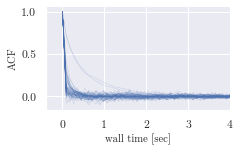

In [30]:
acf = pd.concat([rfx_acf.reset_index(), prec_acf.reset_index()]).melt(id_vars=['algo', 'factor', 'level', 'response'], var_name='lag')
acf['level'] = acf.level.fillna(0)
acf['factor'] = acf.factor.astype('category').cat.codes
acf['group'] = (acf.factor.astype('str') + '-' + acf.level.astype('str')).astype('category').cat.codes
acf['time'] = acf.lag.astype(int) * cgibbs_titer
#acf = acf.loc[~((acf.lag.astype(int) > 10) & (acf.lag.astype(int) % 10 != 0))]

g = sns.relplot(data=acf, x='time', y='value', kind='line', style='group', dashes=False, markers=False, legend=False, height=2, aspect=8/5, ci=None, alpha=1/3, lw=1/3)
plt.xlim(-0.4, 4)
g.set(xlabel='wall time [sec]', ylabel='ACF')
g.set_titles(col_template='{col_name}')
plt.savefig('paper/plots/crossed_unid_acf.pdf', bbox_inches='tight', backend='pgf')

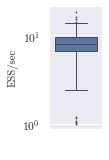

In [34]:
ess = pd.concat([rfx_ess.reset_index(), prec_ess.reset_index()])
ess['level'] = ess.level.fillna(0)

g = sns.catplot(data=ess, y='rate[sec]', kind='box', height=2, aspect=2/3, linewidth=1, fliersize=1, sym='o')
g.set(xlabel='$\\quad$', ylabel='ESS/sec')
plt.yscale('log')
plt.savefig('paper/plots/crossed_unid_ess.pdf', bbox_inches='tight', backend='pgf')